# 0. Introduction

<h1>RUAK - Are you a Hegel?</h1>

> The greatest challenge to any thinker is stating the problem in a way that will allow a solution.

[Bertrand Russell](https://en.wikipedia.org/wiki/Bertrand_Russell)
<br><br>

<h2>About the project</h2>
Philosophy is a fundamental human thought movement. Everyone is a philosopher. The only question is what kind of philosopher you are. This project tries to answer that question. Using natural language processing (NLP), texts of different authors are used for categorization. With the help of these texts any sentence can be categorically determined.
<br>
You can open this Jupyter notebook in Google Colab to use a GPU and have a nice platform for editing.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stoffy/RUAK-text-classifier/blob/master/notebooks/text_classifier.ipynb)

<br><br>

<h2>Information on use</h2>
<h3>Paths:</h3>

The following data needs to be loaded. Please adjust the paths accordingly ([1.2.1](#1-2-1)): 
* Path which contains the text files (`source_path`)
* Path for loading and saving the DataFrame (`dataframe_file_path`)
* Path to Word2Vec model (`word2vec_path`)
* Path to hyperparameter tuner working directory  (`hyperband_tuner_output_path`) 
* Path where the checkpoints from the training process are stored (`checkpoint_path`)
* Path where the model (h5 format) should be stored or loaded from (`model_h5_path`)

<h3>Speed:</h3>

Some processes may take a while depending on the settings and hardware requirements. To speed up the process, certain changes can be made. Obviously, the total amount of data also determines the overall speed.
* [4.2.1 POS tagging](#4-2-1) - this process uses Scapy to tag every word in a sentence. To speed up the process, this process should not be executed. 
* [6.1.1. Prepare values for visualization](#6-1-1) - if `lemmatization_enabled` is set to `True` the list of unique vocabulary for each author is lemmatized. This will slow down the process.
* [8.2. Run the tuner](#8-2) Adjust the parameters to fit your needs
    * `epochs` - Iterations for training
    * `search_epochs` - Iterations for finding the best hyperparameters
    * `executions_per_trial` - Number of models that should be built and fit for each trial for robustness purposes.
    * `hyperband_iterations` - The number of times to iterate over the full Hyperband algorithm.

<h3>Additional information:</h3>    
<br><br>
<h2>Content</h2>

* [1. Preparations](#1)
* [2. Loading text data](#2)
* [3. Collect data and create word collection](#3)
* [4. Create and extend DataFrame](#4)
* [5. Store or load DataFrame](#4)
* [6. Visualization of data](#5)
* [7. Prepare and split](#6)
* [8. Hyperparameter tuning](#7)
* [9. Model preparation](#8)
* [10. Save or load model](#8)
* [11. Evaluation](#11)
* [11. TensorBoad](#12)






# 1. Preparations

In [ ]:
import spacy.cli
!rm -rf ./logs/
!pip install tensorflow_datasets
!pip install -q -U keras-tuner
!pip install -q pyyaml h5py
spacy.cli.download("de_core_news_md")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Imports

In [5]:
import urllib, IPython, os, datetime, re, nltk, tensorboard, operator, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.activations as activations
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import kerastuner as kt
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy import displacy
from spacy.lang.de.stop_words import STOP_WORDS
import de_core_news_md

## 1.2. Downloads for NLTK and Spacy

In [9]:
nltk.download('punkt')
spacy.prefer_gpu()
nlp = de_core_news_md.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1.2. Magic functions and global variables

Magic functions

In [ ]:
%matplotlib inline
%load_ext tensorboard

### 1.2.1. Global variables and paths <a class="anchor" id="1-2-1"></a>

Set `session_id` for providing unique file names

In [13]:
session_id = datetime.datetime.now().strftime("%d/%m/%Y-%H:%M")

In [ ]:
source_path =
dataframe_file_path =
word2vec_path =
hyperband_tuner_output_path =
checkpoint_path =
model_h5_path =

List of files to process and philosopher names. Files should be named after philosophers (e.g. `plato.txt`).

In [14]:
file_names = [
    'kant.txt', 
    'nietzsch.txt', 
    'platon.txt', 
    'rousseau.txt']
    
phil_names = [name[:-4].capitalize() for name in file_names]

## 1.3 Format [stop words](https://en.wikipedia.org/wiki/Stop_word)

In [15]:
def replace_umlaut(string):
    string = string.replace('ä', 'ae')
    string = string.replace('ö', 'oe')
    string = string.replace('ü', 'ue')
    string = string.replace('Ä', 'Ae')
    string = string.replace('Ö', 'Oe')
    string = string.replace('Ü', 'Ue')
    string = string.replace('ß', 'ss')
    return string

stop_words = set([replace_umlaut(word) for word in STOP_WORDS])
print(f'Stop words count: {len(stop_words)}.')

Stop words count: 531.


Manually add stop words.

In [16]:
manual_stop_words = set(['naemlich', 'bloss'])

stop_words = stop_words.union(manual_stop_words)
print(f'Total stop words count: {len(stop_words)}.')

Total stop words count: 533.


# 2. Loading text data

In [17]:
prefix = 'file://'
processed_path = '/content/drive/My Drive/RUAK/input/processed/'
url = urllib.parse.quote(processed_path)

for file_name in file_names:
  text_dir = tf.keras.utils.get_file(file_name, origin=prefix+url+file_name)

parent_dir = os.path.dirname(text_dir)

3874816/3867231 [==============================] - 0s 0us/step


# 3. Collect data and create word collections

## 3.1. Create word collections

Function to add words to `words_without_stop_words` and `unique_words_without_stop_words`.

In [18]:
def add_words(sentence):
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word == '':
      continue
    if word.lower() not in stop_words:
      words_without_stop_words.append(word)
      unique_words_without_stop_words.add(word)

words_without_stop_words = []
unique_words_without_stop_words = set()

Collect most commen words except the stop words.

In [19]:
most_common = [word[0] for word in Counter(words_without_stop_words).most_common(20)]
most_common_count = {k: v for k, v in Counter(words_without_stop_words).most_common(20)}

## 3.2. Extract sentences

Extract sentences from files and creates labels list. Adjust the language for the `nltk.sent_tokenizer` if needed.

In [20]:
labels = []
sentences = []

for index, file_name in enumerate(file_names):

  path = os.path.join(parent_dir, file_name)

  with open(path, 'rb') as file: 
    text = str(file.read())
    nltk_sentences = nltk.sent_tokenize(text, language='german')

    for sentence in nltk_sentences:
      # Some pre-cleaning
      if ' ' in sentence == False:
        continue
      if len(sentence) <= 20:
        continue
      sentence = str(sentence).replace("b'", "")
      sentences.append(sentence)
      labels.append(index)
      add_words(sentence)

    print(f"Sentences for {file_name} with label: {index} added.")

print(f'\n{len(sentences)} sentences found.')
print(f'{len(words_without_stop_words)} words found (excl. stop words).')
print(f'{len(unique_words_without_stop_words)} unique words found (excl. stop words).')

Sentences for kant.txt with label: 0 added.
Sentences for nietzsch.txt with label: 1 added.
Sentences for platon.txt with label: 2 added.
Sentences for rousseau.txt with label: 3 added.

87710 sentences found.
912579 words found (excl. stop words).
88470 unique words found (excl. stop words).


## 3.3. Clean data

In [ ]:
def short_sentences(length):
  short_sentences = [sentence for sentence in sentences if len(sentence.split()) <= length]
  print(f'Found {len(short_sentences)} sentences shorter than {length} words.\n')
  return short_sentences

def long_sentences(length):
  long_sentences = [sentence for sentence in sentences if len(sentence.split()) >= length]
  print(f'Found {len(long_sentences)} sentences longer than {length} words.\n')
  return long_sentences

### 3.3.1. Remove sentences

Set min and max length for sentences

In [ ]:
min_length = 6
max_length = 400

Get invalid sentences

In [ ]:
invalid_sentences = short_sentences(min_length) + long_sentences(max_length)
print(f'Found {len(invalid_sentences)} invalid sentences.')

#### 3.3.1.1. Investigate invalid sentences
Print 5 examples of `invalid_sentences`

In [ ]:
for i in random.sample(range(10, len(invalid_sentences)-1), 10):
  print(invalid_sentences[i])

Use Spacy [Visualizer](https://spacy.io/usage/visualizers) to show a random invalid sentence.

In [ ]:
doc = nlp(invalid_sentences[random.randint(0, len(invalid_sentences)-1)])
displacy.render(doc, style="dep", jupyter=True)

### 3.3.2. Provide cleaned data

In [ ]:
cleaned_labels = []
cleaned_sentences = []
print(f"'sentences' list length before removal: {len(sentences)}.")
for index, sentence in enumerate(sentences):
  if sentence not in invalid_sentences:
    cleaned_sentences.append(sentence)
    cleaned_labels.append(labels[index])  
print(f"'sentences' list length after removal: {len(cleaned_sentences)}.")
print(f'{len(invalid_sentences)} sentences removed.')

# 4. Create and extend DataFrame

Some helper methods

In [77]:
def stop_word_quote_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in stop_words:
      count += 1
  return round(count/len(sentence.split()) * 100, 2)

def stop_word_count_fn(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in stop_words:
      count += 1
  return count

def mean_word_length_fn(sentence):
  return round(np.array([len(word) for word in sentence.replace('.','').split()]).mean(), 2)

def pos_count(sentence, pos):
  doc = nlp(sentence)
  return len([w.pos_ for w in doc if w.pos_ == pos])

## 4.1. Create DataFrame

In [79]:
df = pd.DataFrame({'label': cleaned_labels, 'sentence': cleaned_sentences})
df.head()

,label,sentence
0,0,"Ich habe einen Vorwurf gewaehlt, welcher sowo..."
1,0,"Das Systematische, welches die grossen Glieder..."
2,0,Von der andern Seite droht die Religion mit ei...
3,0,Ich sehe alle diese Schwierigkeiten wohl und w...
4,0,Ich empfinde die ganze Staerke der Hindernisse...


## 4.2. Construct new data

In [80]:
df['philosopher'] = df['label'].map(lambda x: phil_names[x])
df['word_count'] = df['sentence'].str.split().str.len()
df['mean_word_length'] = df['sentence'].map(mean_word_length_fn)
df['stop_words_quote'] = df['sentence'].map(stop_word_quote_fn)
df['stop_words_count'] = df['sentence'].map(stop_word_count_fn)

### 4.2.1 POS tagging <a class="anchor" id="4-2-*1*"></a>
Add columns and values for [POS tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging). Annotations can be found [here](https://spacy.io/api/annotation). **This may take a while!**

In [30]:
pos_tags = ['ADJ', 'ADV', 'ADP', 'AUX', 'DET', 'NUM', 'X', 'INTJ', 'CCONJ', 'SCONJ', 'PROPN', 'NOUN', 'DET', 'PRON', 'PART', 'VERB']
for pos in pos_tags:
  df[f'{pos}_count'] = df['sentence'].map(lambda sen: pos_count(sen, pos))

## 4.3. Preview processed DataFrame

In [81]:
df.head(df.shape[0])

,label,sentence,philosopher,word_count,mean_word_length,stop_words_quote,stop_words_count
0,0,"Ich habe einen Vorwurf gewaehlt, welcher sowo...",Kant,32,6.31,53.12,17
1,0,"Das Systematische, welches die grossen Glieder...",Kant,49,6.39,53.06,26
2,0,Von der andern Seite droht die Religion mit ei...,Kant,51,5.98,56.86,29
3,0,Ich sehe alle diese Schwierigkeiten wohl und w...,Kant,11,5.82,72.73,8
4,0,Ich empfinde die ganze Staerke der Hindernisse...,Kant,15,5.47,60.00,9
...,...,...,...,...,...,...,...
80486,3,Wer sich aber zu sagen erdreistet: ausser der ...,Rousseau,32,4.84,65.62,21
80487,3,Ein solches Dogma steht nur mit einer theokrat...,Rousseau,17,5.59,64.71,11
80488,3,"Der Grund, aus dem Heinrich zur katholischen K...",Rousseau,25,6.20,52.00,13
80489,3,Nachdem ich die wahren Grundsaetze des Staatsr...,Rousseau,55,6.29,56.36,31


# 5. Store or load DataFrame

Save DataFrame to CSV if needed.

In [32]:
df.to_csv('/content/drive/My Drive/RUAK/output/dataframe/dataframe.csv')

Load the DataFrame from CSV if needed.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/RUAK/output/dataframe/dataframe.csv')
df.head()

# 6. Visualization of data

## 6.1 Prepare values for visualization

Count vocabulary

In [83]:
def vocabulary_count_fn(series, lemmatization):
  vocabulary = set()
  for sentence in series:
    if lemmatization == True:
      words = lemmatize(sentence)
    else:
      words = sentence.split()  
    for word in words:
      if word.lower() not in stop_words:
        word = re.sub(r"[^a-zA-Z]+", "", word)
        vocabulary.add(word.lower())
  return len(vocabulary)

[Lemmatize](https://en.wikipedia.org/wiki/Lemmatisation)

In [ ]:
def lemmatize(sentence):
  words = set()
  doc = nlp(sentence)
  for word in doc:
    words.add(word.lemma_)
  return list(words)

### 6.1.1. Prepare values for visualization <a class="anchor" id="6-1-1"></a>

In [ ]:
lemmatization_enabled = False

Prepare values for visualization. *Enable lemmatization to get more a more prezise `unique_vocabulary_count`. This will slow down the process!*

In [85]:
median_sentence_length = df.groupby('philosopher')['word_count'].median()
mean_stop_words = df.groupby('philosopher')['stop_words_quote'].mean()
sentence_count = df.groupby('philosopher')['sentence'].count()
unique_vocabulary_count = df.groupby('philosopher')['sentence'].apply(lambda ser: vocabulary_count_fn(ser, lemmatization_enabled))

## 6.2. Draw visualization

### 6.2.1. Comparing authors

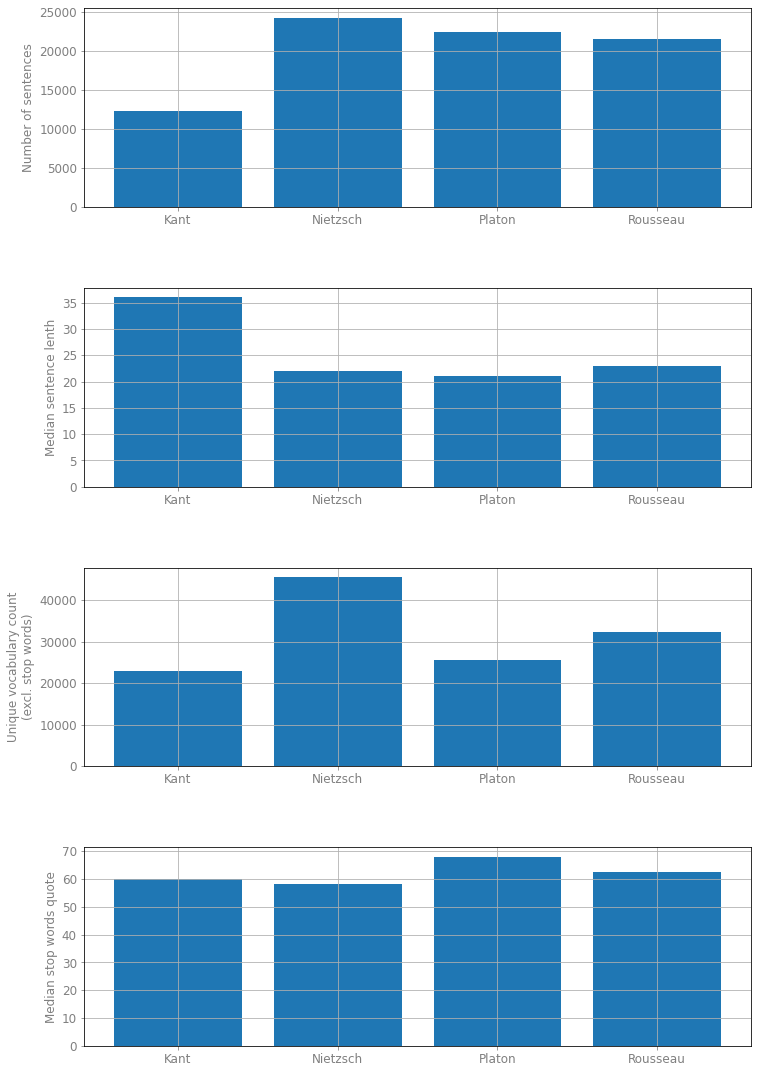

In [86]:
fig, axs = plt.subplots(4,1, figsize=(10,15))

fig.tight_layout(h_pad=6)

axs[0].bar(phil_names, sentence_count)
axs[0].set_ylabel('Number of sentences', fontdict={'color':'gray', 'size':12})
axs[0].tick_params(axis='both', colors='gray', labelsize=12)
axs[0].grid()

axs[1].bar(phil_names, median_sentence_length)
axs[1].set_ylabel('Median sentence lenth', fontdict={'color':'gray', 'size':12})
axs[1].tick_params(axis='both', colors='gray', labelsize=12)
axs[1].grid()

axs[2].bar(phil_names, unique_vocabulary_count)
axs[2].set_ylabel('Unique vocabulary count\n(excl. stop words)', fontdict={'color':'gray', 'size':12})
axs[2].tick_params(axis='both', colors='gray', labelsize=12)
axs[2].grid()

axs[3].bar(phil_names, mean_stop_words)
axs[3].set_ylabel('Median stop words quote', fontdict={'color':'gray', 'size':12})
axs[3].tick_params(axis='both', colors='gray', labelsize=12)
axs[3].grid()

plt.show()

### 6.2.2. Common words in sentences

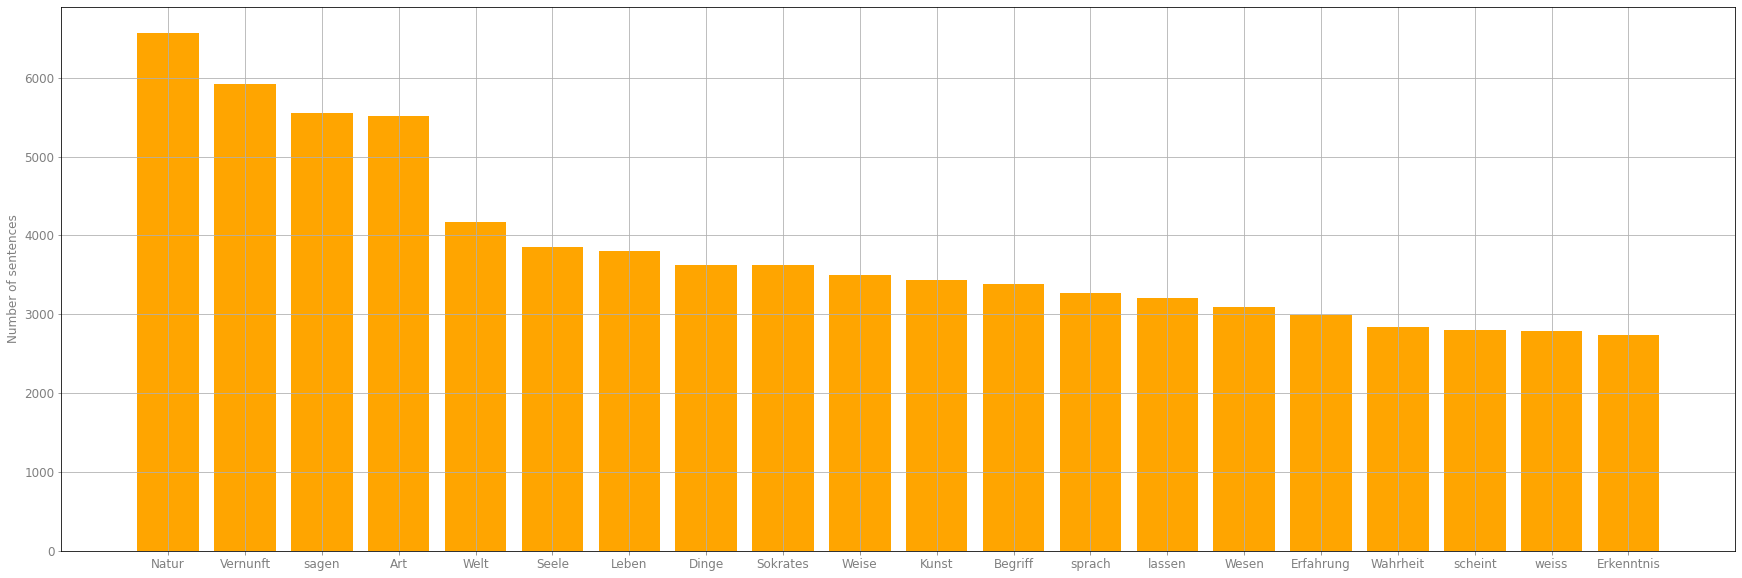

In [90]:
fig, axs = plt.subplots(1,1, figsize=(30,10))

axs.bar(most_common_count.keys(), most_common_count.values(), color='orange')
axs.set_ylabel('Number of sentences', fontdict={'color':'gray', 'size':12})
axs.tick_params(axis='both', colors='gray', labelsize=12)
axs.grid()

plt.show()

### 6.2.3. Word cloud

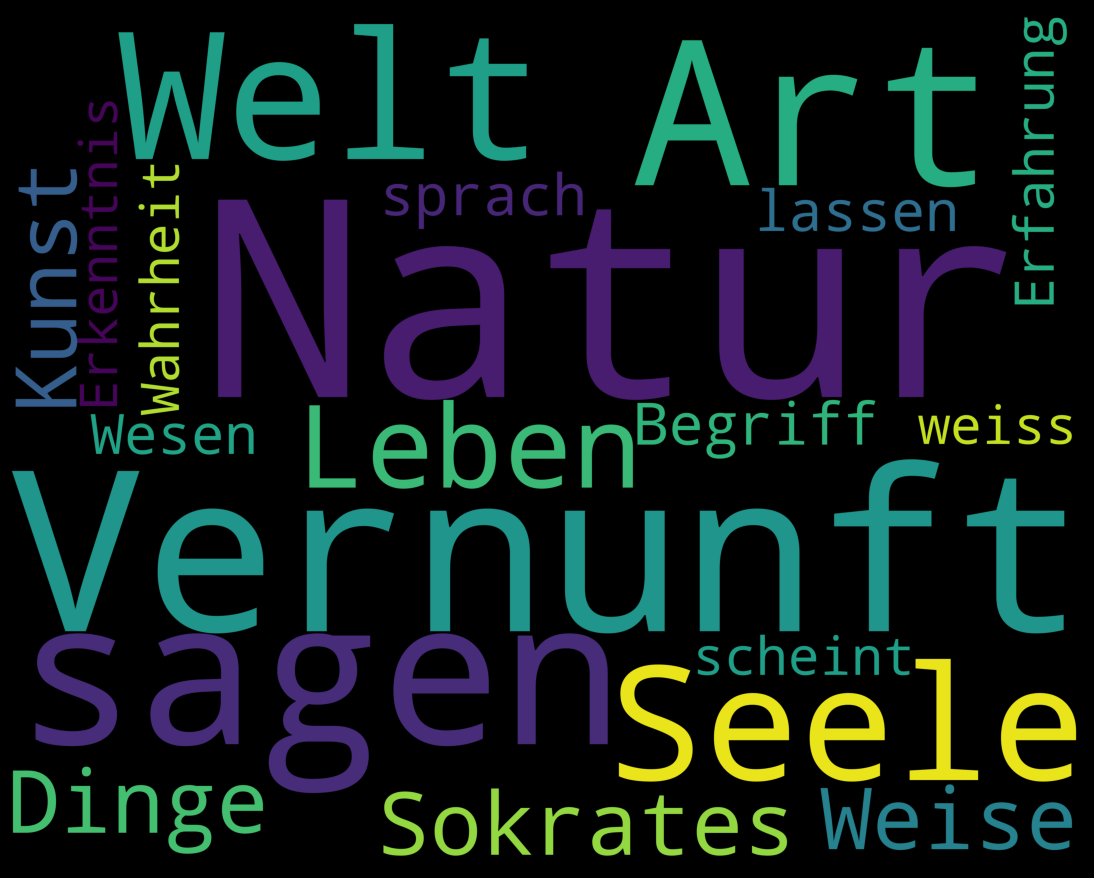

In [91]:
wordcloud = WordCloud(width=5000, 
                      height=4000,
                      max_words=20,  
                      background_color ='black', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate_from_frequencies(most_common_count) 

plt.figure(figsize=(20, 12), facecolor='k', edgecolor ='k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show() 

# 7. Prepare and split

## 7.1. Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentence'].values)
print(f"{len(df['sentence'].values)} sentences from {len(file_names)} authors.")
print(f'{len(tokenizer.word_counts)} unique vocabularies.')

## 7.2. Encode

In [ ]:
encoded_sentences = tokenizer.texts_to_sequences(df['sentence'].values)
padded_sentences = pad_sequences(encoded_sentences, padding='post')

Test the encoder

In [ ]:
print(df['sentence'].values[7])
print(np.array(padded_sentences[7]))
print(tokenizer.sequences_to_texts([padded_sentences[7]]))

## 7.3. Splitting
Create train and test data for the fitting proccess.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(padded_sentences, df['label'].values, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

# 8. Hyperparameter tuning

## 8.1. Setup the hypermodel
Load the Word2Vec model (700 dims, 100 epochs, window 7) for providing the weights for the embedding layer.

In [ ]:
model_path = os.path.abspath("/content/drive/My Drive/RUAK/output/embedding/w2v/") # This path may need to be changed.

def get_embedding_matrix(model_name):
    model = Word2Vec.load(f'{model_path}/{model_name}')
    embedding_matrix = np.zeros((len(model.wv.vocab), model.vector_size))
    
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print(f"Embedding_matrix shape: {embedding_matrix.shape}")
    return embedding_matrix

embedding_matrix = get_embedding_matrix('full_700_iter100_win7_8.model')

Define the model

In [ ]:
def hypermodel(hp):

  hp_dense_count = hp.Int('dense_count', min_value=1, max_value=7, step=1)
  hp_embedding_trainable = hp.Choice('embedding_trainable', [True, False])
  hp_with_batch_normalization = hp.Choice('with_batch_normalization', [True, False])
  hp_lstm_units = hp.Int('lstm_units', 256, 512, step=128)
  hp_dropout = hp.Choice('dropout', [0.0, 0.1, 0.25])
  hp_learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
  hp_adam_epsilon = hp.Choice('adam_epsilon', values=[1e-07, 1e-08])

  model = tf.keras.Sequential()
                                    
  model.add(Embedding(len(embedding_matrix),
                    output_dim=700,
                    weights=[embedding_matrix], 
                    trainable=hp_embedding_trainable,
                    mask_zero=True))
  
  model.add(Bidirectional(LSTM(hp_lstm_units, return_sequences=True)))
  if hp_embedding_trainable == True:
    BatchNormalization()
  model.add(Dropout(hp_dropout))

  model.add(Bidirectional(LSTM(hp_lstm_units, return_sequences=True)))
  if hp_embedding_trainable == True:
    BatchNormalization()  
  model.add(Dropout(hp_dropout))

  model.add(Bidirectional(LSTM(hp_lstm_units)))
  if hp_embedding_trainable == True:
    BatchNormalization()  
  model.add(Dropout(hp_dropout))

  for i in range(hp_dense_count):
    hp_dense_units = hp.Int(f'dense_units{i}', 64, 512, step=64)
    hp_dense_activation = hp.Choice(f'dense_activation_{i}', values=['tanh', 'relu'])
    model.add(Dense(hp_dense_units, activation=hp_dense_activation))

  model.add(Dense(len(file_names), activation='softmax'))

  model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, epsilon=hp_adam_epsilon),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

## 8.2. Run the tuner
Some parameters needed for tuning and training.

In [ ]:
batch_size=40
epochs=1
search_epochs=1
early_stopping_patience=5
executions_per_trial=1
hyperband_iterations=1

The result are the optimal hyperparameters: `best_hps`.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait=True)

tuner = kt.Hyperband(hypermodel,
                     objective='val_accuracy', 
                     executions_per_trial=executions_per_trial,
                     factor=3,
                     max_epochs=epochs+5,
                     hyperband_iterations=hyperband_iterations,
                     directory='/content/drive/My Drive/RUAK/output/hp_tuning', # This path may need to be changed.
                     project_name='RUAK',
                     overwrite=True)

tuner.search(X_train, y_train, 
             epochs=search_epochs,
             validation_data = (X_valid, y_valid),
             callbacks = [ClearTrainingOutput(), EarlyStopping('val_accuracy', patience=1)],
             verbose=2)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_models = tuner.get_best_models(num_models=3)

print(f"""
Optimal values:
- embedding is trainable {best_hps.get('embedding_trainable')}
- number of units for dense layers {best_hps.get('dense_units')}
- number of units for lstm layers {best_hps.get('lstm_units')}
- learning rate {best_hps.get('learning_rate')}
- dropout rate {best_hps.get('dropout')}
""")

tuner.results_summary()

# 9. Model preparation

Get summaries of the best models and choose the model for training.

In [ ]:
for model in best_models:
  model.summary()

Choose preferred model

In [ ]:
chosen_model = best_models[0]

Plot model structure

In [ ]:
plot_model(chosen_model, show_shapes=True, show_layer_names=True)

## 9.1. Prepare callbacks
TensorBoard preparation

In [ ]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%d/%m/%Y - %H:%M"))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Prepare `ModelCheckpoint` and `EarlyStopping` callbacks.

In [ ]:
checkpoint_path = f"/content/drive/My Drive/RUAK/output/training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

es_callback = EarlyStopping('val_accuracy', patience=early_stopping_patience, restore_best_weights=True)

## 9.2. Model training

In [ ]:
 history = chosen_model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_valid, y_valid), 
                            callbacks=[cp_callback, es_callback, tb_callback])

# 10. Save or load model

## 10.1. Save model

In [ ]:
model.save('/content/drive/My Drive/RUAK/output/models/phil_model.h5')

## 10.2. Load model

In [ ]:
chosen_model = tf.keras.models.load_model('/content/drive/My Drive/RUAK/output/models/phil_model.h5') # This path may need to be changed.

## 10.3. Load stored weights

In [ ]:
checkpoint_path = f"/content/drive/My Drive/RUAK/training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
chosen_model.load_weights(latest)

# 11. Evaluation

## 11.1. Show loss and accuracy

In [ ]:
test_loss, test_acc = chosen_model.evaluate(valid_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

## 11.2. Test the model

Test the model. Add a `sample_sentence` to get the probability distribution for each author.

In [ ]:
sample_sentence = "Die Vernunft ist staerker als der Wille."

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_text, pad):
  encoded_sample_text = encoder.encode(sample_text)
  if pad:
    encoded_sample_text = pad_to_size(encoded_sample_text, batch_size)
  encoded_sample_text = tf.cast(encoded_sample_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_text, 0))
  return (predictions)

predictions = sample_predict(sample_sentence_text, pad=True)

print(predictions)

# 12. TensorBoard <a class="anchor" id="12"></a>

In [ ]:
%tensorboard --logdir logs